# Disaster Tweets Classification using DL Word Embeddings

## Loading Libraries

In [192]:
import pandas as pd
import numpy as np

import re
import string
import os

import matplotlib.pyplot as plt
import seaborn as sns

from wordcloud import WordCloud

# scikit-learn
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report
from sklearn.svm import LinearSVC

plt.style.use('ggplot')

# tensorflow
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, Flatten, Embedding, Dropout
from tensorflow.keras.layers import Conv1D, GlobalMaxPooling1D, MaxPooling1D
from tensorflow.keras.optimizers import Adam

# warnings
import warnings
warnings.filterwarnings('ignore')

In [193]:
# !pip install git+https://github.com/troyhunterz/preprocess_tr.git
# !pip install textblob
# !python -m spacy download en_core_web_lg

## Loading Data

In [194]:
tweet = pd.read_csv('dataset/data.csv')

## Exploring Data

In [195]:
print(f'rows: {tweet.shape[0]}\ncolumns:{tweet.shape[1]}')
tweet.sample(5) # 1 - disaster | 0 - non-disaster

rows: 7613
columns:5


,id,keyword,location,text,target
5643,8047,refugees,"Auckland, New Zealand",http://t.co/eHKLp12yiP Paci?c Media Centre | a...,0
2674,3836,detonate,"Morioh, Japan",@spinningbot Are you another Stand-user? If yo...,0
5566,7941,rainstorm,"Memphis, TN",That rainstorm didn't last nearly long enough,1
3541,5063,famine,"New York, USA",'Food crematoria' provoke outrage amid crisis ...,1
7350,10522,wildfire,NaN,This machine really captured my attention. #he...,1


In [196]:
tweet.describe()

,id,target
count,7613.000000,7613.00000
mean,5441.934848,0.42966
std,3137.116090,0.49506
min,1.000000,0.00000
25%,2734.000000,0.00000
50%,5408.000000,0.00000
75%,8146.000000,1.00000
max,10873.000000,1.00000


## Exploratory Data Analysis

In [197]:
plt.rcParams['figure.figsize'] = [10,5]
plt.rcParams['figure.dpi'] = 90

### Target Class Distribution

In [198]:
tweet

,id,keyword,location,text,target
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1
4,7,NaN,NaN,Just got sent this photo from Ruby #Alaska as ...,1
...,...,...,...,...,...
7608,10869,NaN,NaN,Two giant cranes holding a bridge collapse int...,1
7609,10870,NaN,NaN,@aria_ahrary @TheTawniest The out of control w...,1
7610,10871,NaN,NaN,M1.94 [01:04 UTC]?5km S of Volcano Hawaii. htt...,1
7611,10872,NaN,NaN,Police investigating after an e-bike collided ...,1


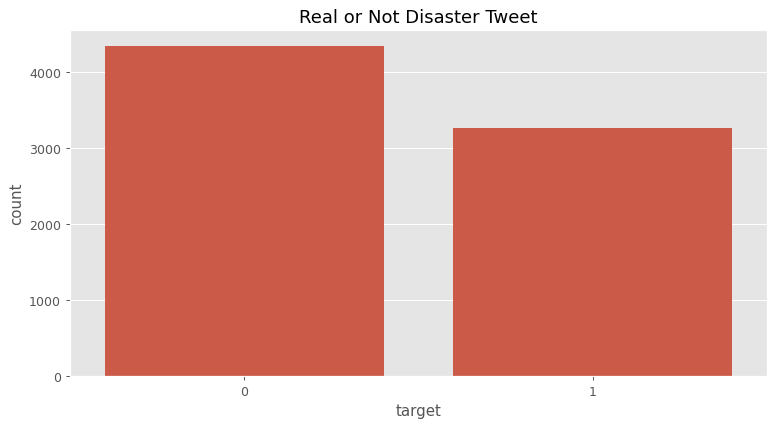

In [199]:
sns.countplot(tweet, x='target')
plt.title('Real or Not Disaster Tweet');

In [200]:
tweet['target'].value_counts()

target
0    4342
1    3271
Name: count, dtype: int64

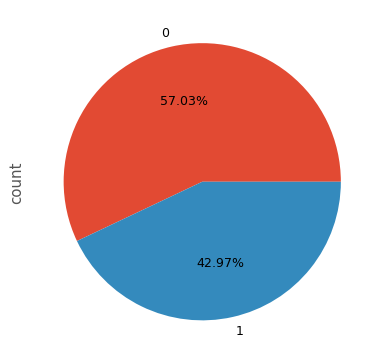

In [201]:
tweet['target'].value_counts().plot.pie(autopct='%1.2f%%');

## Numbers or Characters Distribution in Tweets

In [202]:
import preprocess_tr as ps

In [203]:
def digit_counts(x):
    digits = re.findall(r'[0-9,.]+', x)
    return len(digits)

In [204]:
def get_basic_features(df):
    if type(df) == pd.core.frame.DataFrame:
        df['char_counts'] = df['text'].apply(lambda x: ps.char_count(x))
        df['word_counts'] = df['text'].apply(lambda x: ps.word_count(x))
        df['avg_wordlength'] = df['text'].apply(lambda x: ps.avg_word_len(x))
        df['stopwords_counts'] = df['text'].apply(lambda x: ps.stopwords_count(x))
        df['hastag_counts'] = df['text'].apply(lambda x: ps.hashtags_count(x))
        df['mentions_counts'] = df['text'].apply(lambda x: ps.mentions_count(x))
        df['digit_counts'] = df['text'].apply(lambda x: digit_counts(x))
        df['uppercase_counts'] = df['text'].apply(lambda x: ps.uppers_count(x))
    else:
        print('ERROR: This function takes only Pandas DataFrame')
    
    return df

In [205]:
tweet = get_basic_features(tweet)
tweet.head(3)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,8,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,11,0,0,1,0


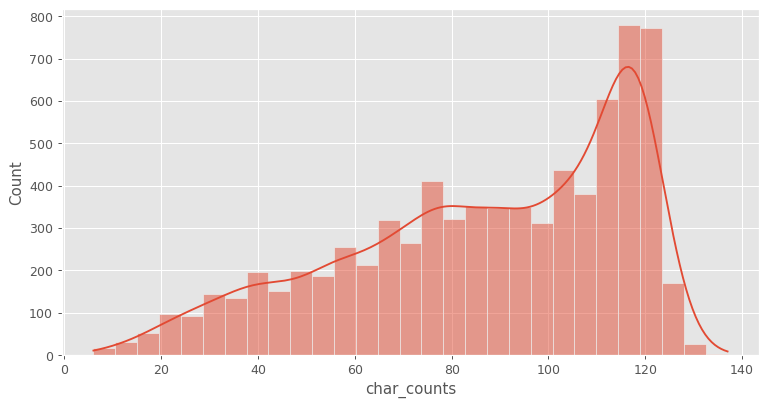

In [206]:
sns.histplot(tweet['char_counts'], kde=True); # 140 max

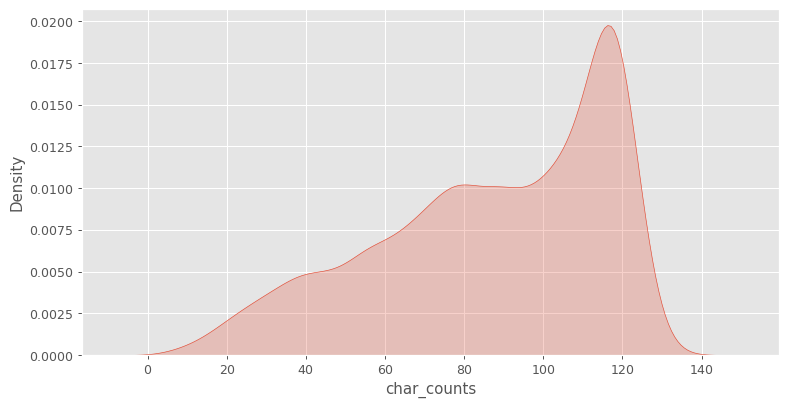

In [207]:
sns.kdeplot(tweet['char_counts'], fill=True);

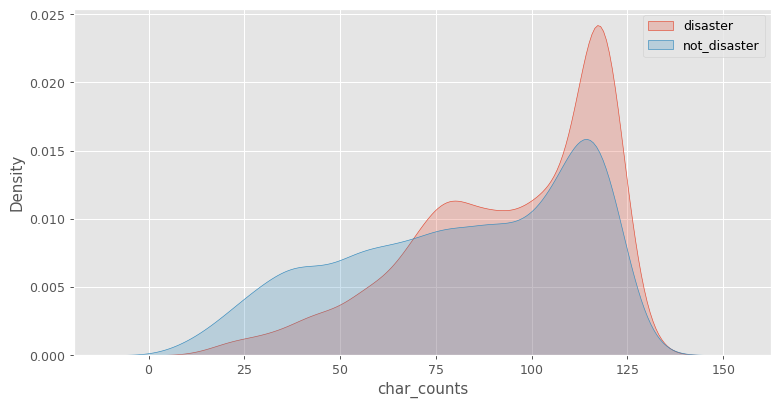

In [208]:
sns.kdeplot(tweet[tweet['target']==1]['char_counts'], fill=True, label='disaster')
sns.kdeplot(tweet[tweet['target']==0]['char_counts'], fill=True, label='not_disaster')
plt.legend();

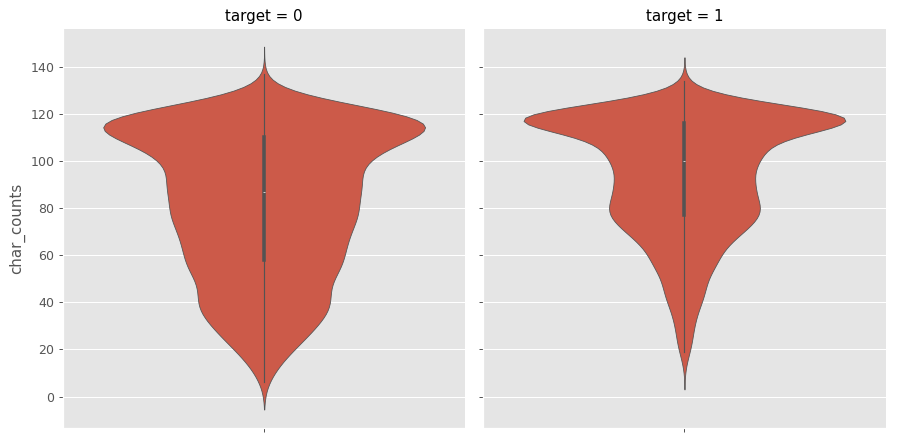

In [209]:
sns.catplot(y='char_counts', data=tweet, kind='violin', col='target');

### Numbers of Words, Average Words Length and Stop Words Distribution in Tweets

In [210]:
tweet.head(4)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts
0,1,NaN,NaN,Our Deeds are the Reason of this #earthquake M...,1,57,13,4.384615,8,1,0,0,1
1,4,NaN,NaN,Forest fire near La Ronge Sask. Canada,1,32,7,4.571429,0,0,0,1,0
2,5,NaN,NaN,All residents asked to 'shelter in place' are ...,1,112,22,5.090909,11,0,0,1,0
3,6,NaN,NaN,"13,000 people receive #wildfires evacuation or...",1,57,8,7.125000,1,1,0,1,0


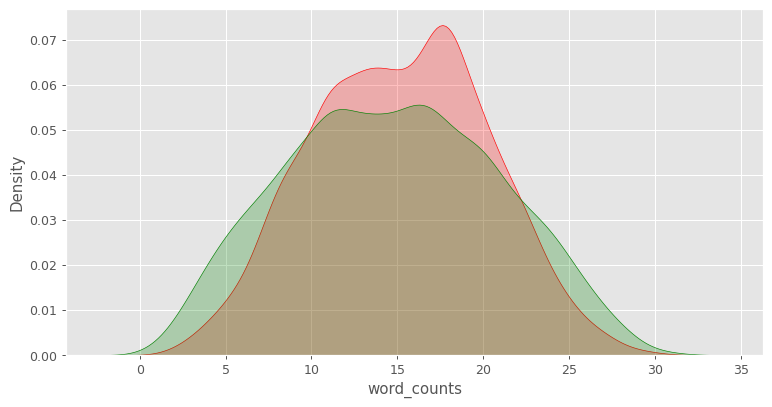

In [211]:
sns.kdeplot(tweet[tweet['target']==1]['word_counts'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['word_counts'], fill=True, color='green');

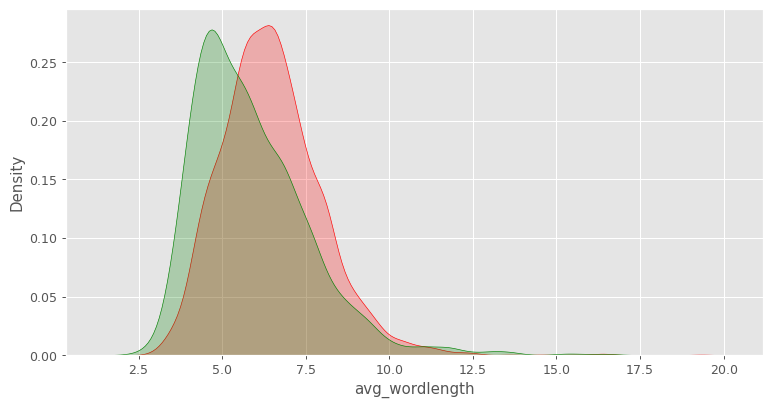

In [212]:
sns.kdeplot(tweet[tweet['target']==1]['avg_wordlength'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['avg_wordlength'], fill=True, color='green');

<Axes: xlabel='stopwords_counts', ylabel='Density'>

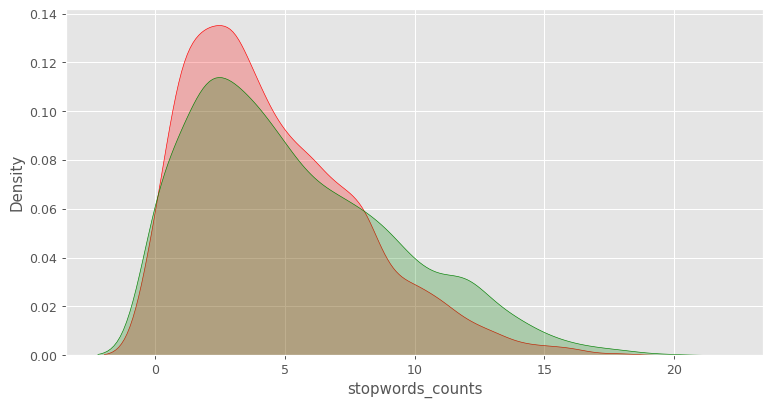

In [213]:
sns.kdeplot(tweet[tweet['target']==1]['stopwords_counts'], fill=True, color='red')
sns.kdeplot(tweet[tweet['target']==0]['stopwords_counts'], fill=True, color='green')

### Most and Least Common Words

In [214]:
def word_freq(df, col):
    text = ' '.join(df[col])
    text = text.split()
    freq = pd.Series(text).value_counts()
    return freq

In [215]:
freqs = word_freq(tweet, 'text')
top10 = freqs[:20]

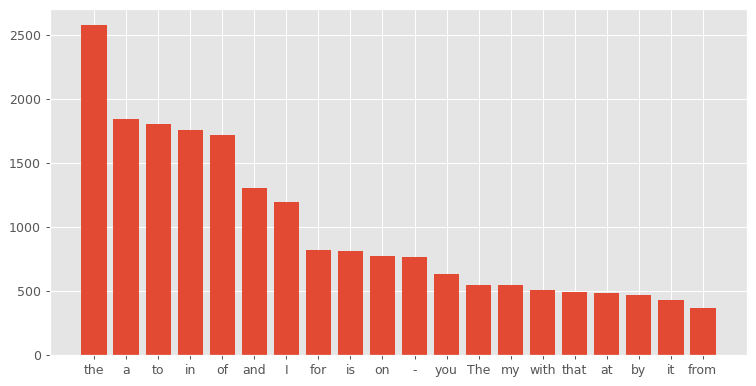

In [216]:
plt.bar(top10.index, top10.values);

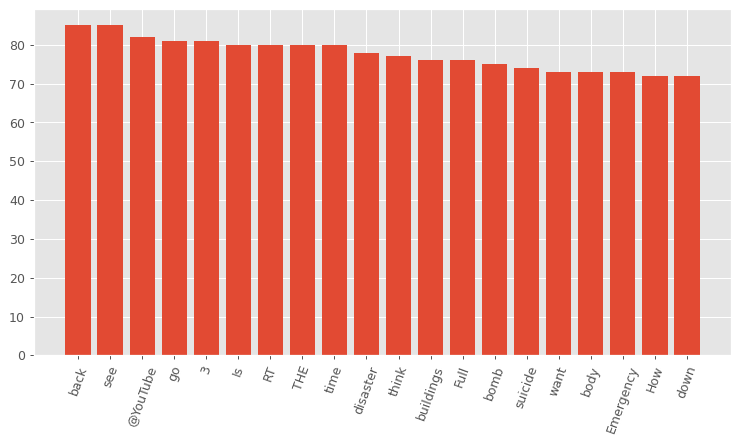

In [217]:
top = freqs[100:120]
plt.bar(top.index, top.values)
plt.xticks(rotation=70);

In [218]:
leasts20 = freqs[-20:]
leasts20

http://t.co/JD7rIK7fX0     1
ft.åÊM.O.P.                1
http://t.co/ZDTz3RbS6w     1
'Detonate.'                1
@ApolloBrown's             1
PLAY                       1
missed.                    1
detonate&amp;Shots         1
succeed                    1
marines                    1
@BBCTalkback               1
@rfcgeom66                 1
@tomfromireland            1
@SourMashNumber7           1
#FIYA!                     1
https://t.co/NlJVP3Vfyz    1
(Ft.                       1
Dix                        1
bandolier                  1
http://t.co/YmY4rSkQ3d     1
Name: count, dtype: int64

In [219]:
def get_ngram(df, col, ngram_range):
    vectorizer = CountVectorizer(ngram_range=(ngram_range, ngram_range))
    vectorizer.fit_transform(df[col])
    ngram = vectorizer.vocabulary_
    ngram = sorted(ngram.items(), key=lambda x: x[1], reverse=True)

    return ngram

In [220]:
bigram = get_ngram(tweet, 'text', ngram_range=2)
bigram[:4]

[('ûówe work', 68495),
 ('ûótech business', 68494),
 ('ûónegligence and', 68493),
 ('ûókody vine', 68492)]

## Data Cleaning

In [221]:
def dups_char(x):
    x = re.sub('(.)\\1{2,}', '\\1', x)
    return x

In [222]:
def clean_data(x):
    x = str(x).lower().replace('\\',' ').replace('_', ' ').replace('.', ' ')
    x = ps.contraction_to_expansion(x)
    x = ps.remove_emails(x)
    x = ps.remove_urls(x)
    x = ps.rm_html(x)
    x = ps.rm_accented_chars(x)
    x = ps.rm_special_chars(x)
    x = dups_char(x)
    return x

In [223]:

tweet['text'] = tweet['text'].apply(lambda x: clean_data(x))

In [224]:
tweet.head(5)['text']

0    our deeds are the reason of this earthquake ma...
1                forest fire near la ronge sask canada
2    all residents asked to shelter in place are be...
3    130 people receive wildfires evacuation orders...
4    just got sent this photo from ruby alaska as s...
Name: text, dtype: object

## Disaster Words Visualization with Word Cloud

In [225]:
real_dis = word_freq(tweet[tweet['target']==1], 'text')
real_dis = ' '.join(real_dis.index)
# real_dis

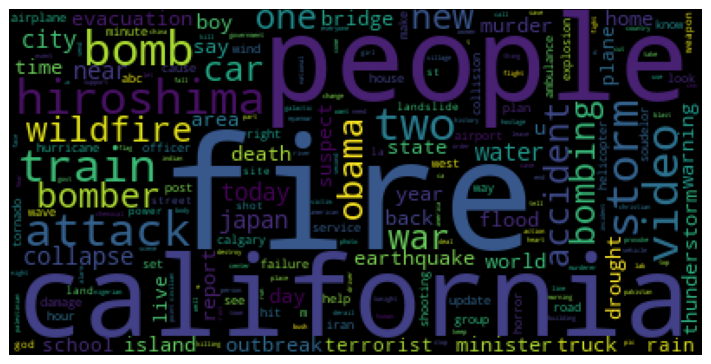

In [226]:
word_cloud = WordCloud(max_font_size=90).generate(real_dis)
plt.imshow(word_cloud)
plt.axis('off');

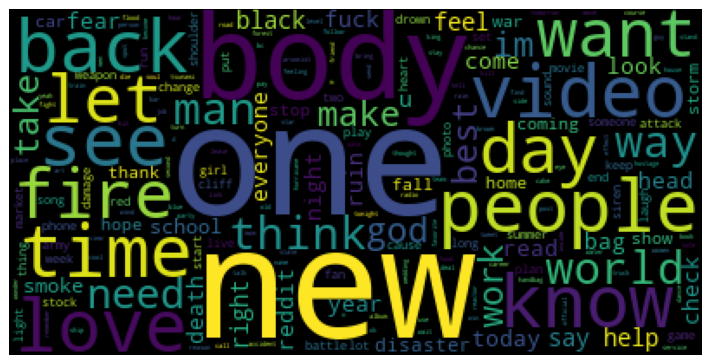

In [227]:
nreal_dis = word_freq(tweet[tweet['target']==0], 'text')
nreal_dis = ' '.join(nreal_dis.index)

word_cloud = WordCloud(max_font_size=90).generate(nreal_dis)
plt.imshow(word_cloud)
plt.axis('off');

## Classification with TFIDF and SVM

In [228]:
text = tweet['text']
y = tweet['target']

tfidf = TfidfVectorizer()

X = tfidf.fit_transform(text)

In [229]:
X, X.shape

(<7613x22357 sparse matrix of type '<class 'numpy.float64'>'
 	with 103450 stored elements in Compressed Sparse Row format>,
 (7613, 22357))

In [230]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [231]:
def run_svm(clf, X_train, X_test, y_train, y_test):
    clf.fit(X_train, y_train)
    y_pred = clf.predict(X_test)

    print(classification_report(y_test, y_pred))
    print(confusion_matrix(y_test, y_pred))

In [232]:
%%time
clf = LinearSVC(dual=True)
run_svm(clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.79      0.89      0.84       869
           1       0.82      0.69      0.75       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.79      1523
weighted avg       0.80      0.80      0.80      1523

[[773  96]
 [205 449]]
CPU times: total: 62.5 ms
Wall time: 41.6 ms


## Prediction on Test Data

In [233]:
def get_predict(x):
    x = clean_data(x)
    predict = clf.predict(tfidf.transform([x]))
    if predict[0] == 1:
        print(x, '--->>> [disaster]')
    elif predict[0] == 0:
        print(x, '--->>> [not_disaster]')

In [234]:
get_predict('there is fire in the forest'), get_predict('happy birthday'), get_predict('goverment has recently started regitration for covid-19 vaccine'), get_predict('trump threatned with nuclear war');

there is fire in the forest --->>> [disaster]
happy birthday --->>> [not_disaster]
goverment has recently started regitration for covid19 vaccine --->>> [not_disaster]
trump threatned with nuclear war --->>> [disaster]


## Classification with `word2vec` and `SVM`

In [235]:
import spacy
import en_core_web_lg

nlp = en_core_web_lg.load()

In [236]:
def get_vec(x):
    doc = nlp(x)
    vec = doc.vector
    return vec

In [237]:
tweet['vec'] = tweet['text'].apply(lambda x: get_vec(x))
tweet.head(3)

,id,keyword,location,text,target,char_counts,word_counts,avg_wordlength,stopwords_counts,hastag_counts,mentions_counts,digit_counts,uppercase_counts,vec
0,1,NaN,NaN,our deeds are the reason of this earthquake ma...,1,57,13,4.384615,8,1,0,0,1,"[-0.26623327, 0.05843069, -0.1404636, -0.05265..."
1,4,NaN,NaN,forest fire near la ronge sask canada,1,32,7,4.571429,0,0,0,1,0,"[-0.014817425, -0.09212343, -0.10716944, -0.33..."
2,5,NaN,NaN,all residents asked to shelter in place are be...,1,112,22,5.090909,11,0,0,1,0,"[0.0059339865, 0.016337818, -0.105279535, -0.0..."


In [238]:
X = tweet['vec'].to_numpy()
X = X.reshape(-1, 1)
X.shape

(7613, 1)

In [239]:
X = np.concatenate(np.concatenate(X, axis=0), axis=0).reshape(-1, 300)
X.shape

(7613, 300)

In [240]:
y = tweet['target']
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [241]:
%%time
clf = LinearSVC(dual='auto')
run_svm(clf, X_train, X_test, y_train, y_test)

              precision    recall  f1-score   support

           0       0.80      0.88      0.84       869
           1       0.81      0.71      0.76       654

    accuracy                           0.80      1523
   macro avg       0.81      0.79      0.80      1523
weighted avg       0.81      0.80      0.80      1523

[[762 107]
 [190 464]]
CPU times: total: 438 ms
Wall time: 442 ms


## Word Embedding and Classification with DL

In [242]:
token = Tokenizer()
token.fit_on_texts(text)

vocab_size = len(token.word_index) + 1
vocab_size

22394

In [243]:
# print(token.word_index)

In [244]:
encoded_text = token.texts_to_sequences(text)
# print(encoded_text)

In [245]:
max_length = 40 # word_counts
X = pad_sequences(encoded_text, maxlen=max_length, padding='post')

In [246]:
X

array([[ 108, 4535,   21, ...,    0,    0,    0],
       [ 182,   41,  221, ...,    0,    0,    0],
       [  38, 1691, 1441, ...,    0,    0,    0],
       ...,
       [2729, 2314, 4527, ...,    0,    0,    0],
       [  73, 1098,   40, ...,    0,    0,    0],
       [   1,  201,   53, ...,    0,    0,    0]])

In [247]:
X.shape

(7613, 40)

In [248]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=0, stratify=y)

In [249]:
vec_size = 100
model = Sequential()
model.add(Embedding(vocab_size, vec_size))

model.add(Conv1D(32, 2, activation='relu'))
model.add(MaxPooling1D(2))
model.add(Dropout(.5))

model.add(Dense(32, activation='relu'))
model.add(Dropout(.5))

model.add(Dense(16, activation='relu'))
model.add(GlobalMaxPooling1D())

model.add(Dense(1, activation='sigmoid'))

model.build(input_shape=(None, max_length))
model.summary()

Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)         │ (None, 40, 100)        │     2,239,400 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv1d_3 (Conv1D)               │ (None, 39, 32)         │         6,432 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling1d_3 (MaxPooling1D)  │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_6 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 19, 32)         │         1,056 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_7 (Dropout)             │ (None, 19, 32)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 19, 16)         │           528 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ global_max_pooling1d_3          │ (None, 16)             │             0 │
│ (GlobalMaxPooling1D)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │            17 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 2,247,433 (8.57 MB)

 Trainable params: 2,247,433 (8.57 MB)

 Non-trainable params: 0 (0.00 B)

In [250]:
%%time
model.compile(optimizer='Adam', loss='binary_crossentropy', metrics=['accuracy'])
model.fit(X_train, y_train, epochs=5, validation_data=(X_test, y_test))

Epoch 1/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 4s 11ms/step - accuracy: 0.5710 - loss: 0.6801 - val_accuracy: 0.7715 - val_loss: 0.5427
Epoch 2/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.7813 - loss: 0.4932 - val_accuracy: 0.8129 - val_loss: 0.4526
Epoch 3/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 11ms/step - accuracy: 0.8737 - loss: 0.3289 - val_accuracy: 0.7971 - val_loss: 0.4543
Epoch 4/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9206 - loss: 0.2217 - val_accuracy: 0.7761 - val_loss: 0.5165
Epoch 5/5
191/191 ━━━━━━━━━━━━━━━━━━━━ 2s 10ms/step - accuracy: 0.9537 - loss: 0.1354 - val_accuracy: 0.7630 - val_loss: 0.5940
CPU times: total: 1min 15s
Wall time: 11.8 s


In [251]:
def get_encoded(x):
    x = clean_data(x)
    x = token.texts_to_sequences([x])
    x = pad_sequences(x, maxlen=max_length, padding='post')
    return x

In [252]:
vec = get_encoded('i love fruits')
vec

array([[   6,  109, 4542,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0,    0,    0,    0,    0,
           0,    0,    0,    0,    0,    0,    0]])

In [253]:
def get_results(text):
    vec = get_encoded(text)
    pred = model.predict(vec)
    pred_class = (pred>0.5).astype(int)
    if pred_class == 0:
        print(f'[not disaster] | {pred}')
    elif pred_class == 1:
        print(f'[disaster] | {pred}')

In [254]:
get_results('california is on fire.')

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 77ms/step
[disaster] | [[0.83994853]]
